# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
import torch
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torch import nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import datasets, models

import numpy as np
np.random.seed(42) # reproduction

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

#### extra packages

import splitfolders # train-validation-split (image folder with subfolders)

from torchsummary import summary # model summary to see layer shapes

In [2]:
#train-validation-split (image folder with subfolders)
splitfolders.ratio('./images/train', output="output", seed=42, ratio=(0.8, 0.2))

Copying files: 4996 files [00:08, 573.18 files/s]


In [3]:
# TODO: Write data loaders for training, validation, and test sets
# Specify appropriate transforms, and batch_sizes

# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 64

# convert data to a normalized torch.FloatTensor
transform = {'train': 
             transforms.Compose([
                 transforms.Resize(size=(224, 224)),
                 transforms.RandomHorizontalFlip(p=0.2),  # p=0.5 default
                 transforms.RandomRotation(degrees=90),
                 transforms.ToTensor(),
                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]),
             
             'valid': #no data augmentation to keep validation images as original as possible
             transforms.Compose([ 
                 transforms.Resize(size=(224, 224)),
                 transforms.ToTensor(),
                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                          
]),
             
             'test': #no data augmentation to keep test images as original as possible
             transforms.Compose([ 
                 transforms.Resize(size=(224, 224)),
                 transforms.ToTensor(),
                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                          
])}

In [4]:
# load and transform test data
train_data = datasets.ImageFolder('./output/train', transform=transform['train'])
valid_data = datasets.ImageFolder('./output/val', transform=transform['valid'])
test_data = datasets.ImageFolder(root='./images/test', transform=transform['test'])

In [5]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          num_workers=num_workers,
                                          shuffle=True)

In [6]:
# check batch sizes
for dataset in [train_loader, valid_loader, test_loader]:
    print('Size of {}: {}'.format(dataset, len(dataset)))

Size of <torch.utils.data.dataloader.DataLoader object at 0x0000028EAF757D60>: 75
Size of <torch.utils.data.dataloader.DataLoader object at 0x0000028EAF757EB0>: 29
Size of <torch.utils.data.dataloader.DataLoader object at 0x0000028EAF757CA0>: 20


In [7]:
# choose the training and test datasets
loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

I have resized the images with Resized() so that the images all have the same resolution. I have chosen to output an squared image in 224 by 224 pixels format that fits the transfer learning algorithm later as well. The downsizing is good for performance, but there will be less variance in the images then. The computation will be way faster than with the original images, but less accurate.

With regards to data augmentation, I have added RandomHorizontalFlip() with a probability of 20% chance and RandomRotation() with up to 90 degrees. Augmentation will only be applied to the train set as it adds some (artificial) variance to the data that that has been lost due to resizing; validation- and test set will kept as original as possible (but will be resized to the same resolution, too).

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


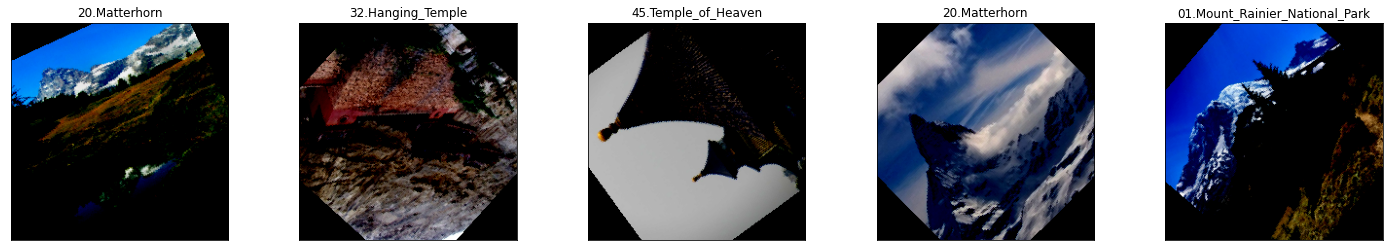

In [8]:
## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in range(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx]))
    ax.set_title(train_data.classes[labels[idx]])

### Initialize use_cuda variable

In [9]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

if not use_cuda :
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [10]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss() # difference between two probability distributions

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001) # currently one of the best optimizers with momentum
    return optimizer 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [11]:
# import torch.nn as nn # already imported

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1) 
        # convolutional layer ()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        # convolutional layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # linear layer
        self.fc1 = nn.Linear(in_features=(128*7*7), out_features=500)
        # linear layer
        self.fc2 = nn.Linear(in_features=500, out_features=50)
        # dropout layer
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 128*7*7)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x
        

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [12]:
summary(model_scratch, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
         MaxPool2d-2           [-1, 32, 56, 56]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5          [-1, 128, 14, 14]          73,856
         MaxPool2d-6            [-1, 128, 7, 7]               0
           Dropout-7                 [-1, 6272]               0
            Linear-8                  [-1, 500]       3,136,500
           Dropout-9                  [-1, 500]               0
           Linear-10                   [-1, 50]          25,050
Total params: 3,254,798
Trainable params: 3,254,798
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.60
Params size (MB): 12.42
Estima

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

I have implemented first of all convolutional layers. Each Conv2d works as a filter detecting special properties of a picture. Those convolutional layers will be activated with an ReLU function, that only positive outputs will be forwarded to the next layer. After each Conv2d layer, there is a MaxPooling layer to return of maximum outputs for better object detection. After this I have added fully connected layers (linear layers with ReLU activation except output layer). I have also added dropout in order to reduce (or even avoid) overfitting.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [13]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss per batch
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
                    # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
                                       
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(),  save_path)
        valid_loss_min = valid_loss        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [14]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1: # for linear layers (except output layer)
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y) # random initialization with standard normal distribution for weights
        m.bias.data.fill_(0) # bias set to zero

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.834828 	Validation Loss: 3.647012
Validation loss decreased (inf --> 3.647012).  Saving model ...
Epoch: 2 	Training Loss: 3.619976 	Validation Loss: 3.470705
Validation loss decreased (3.647012 --> 3.470705).  Saving model ...
Epoch: 3 	Training Loss: 3.488114 	Validation Loss: 3.309705
Validation loss decreased (3.470705 --> 3.309705).  Saving model ...
Epoch: 4 	Training Loss: 3.356093 	Validation Loss: 3.089995
Validation loss decreased (3.309705 --> 3.089995).  Saving model ...
Epoch: 5 	Training Loss: 3.218808 	Validation Loss: 3.004143
Validation loss decreased (3.089995 --> 3.004143).  Saving model ...
Epoch: 6 	Training Loss: 3.121384 	Validation Loss: 2.857294
Validation loss decreased (3.004143 --> 2.857294).  Saving model ...
Epoch: 7 	Training Loss: 3.004595 	Validation Loss: 2.750572
Validation loss decreased (2.857294 --> 2.750572).  Saving model ...
Epoch: 8 	Training Loss: 2.934998 	Validation Loss: 2.638115
Validation loss decreased (2.75057

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [15]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 15 # enough with above model

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.843251 	Validation Loss: 3.706042
Validation loss decreased (inf --> 3.706042).  Saving model ...
Epoch: 2 	Training Loss: 3.670134 	Validation Loss: 3.495561
Validation loss decreased (3.706042 --> 3.495561).  Saving model ...
Epoch: 3 	Training Loss: 3.522926 	Validation Loss: 3.323017
Validation loss decreased (3.495561 --> 3.323017).  Saving model ...
Epoch: 4 	Training Loss: 3.352946 	Validation Loss: 3.219969
Validation loss decreased (3.323017 --> 3.219969).  Saving model ...
Epoch: 5 	Training Loss: 3.241934 	Validation Loss: 3.101772
Validation loss decreased (3.219969 --> 3.101772).  Saving model ...
Epoch: 6 	Training Loss: 3.118564 	Validation Loss: 2.904972
Validation loss decreased (3.101772 --> 2.904972).  Saving model ...
Epoch: 7 	Training Loss: 3.037403 	Validation Loss: 2.825011
Validation loss decreased (2.904972 --> 2.825011).  Saving model ...
Epoch: 8 	Training Loss: 2.950989 	Validation Loss: 2.758034
Validation loss decreased (2.82501

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.632442


Test Accuracy: 33% (423/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [17]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [18]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return optimizer  

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [19]:
model_transfer = models.resnet18(pretrained=True)

# print out the model structure
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
## TODO: Specify model architecture

n_inputs = model_transfer.fc.in_features

# add last linear layer
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(train_data.classes))

model_transfer.fc = last_layer

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

This model is a first good model for large-scale image recognition. For example, it has skip connections offsetting once there are vanishing gradients. It thus enhances the detection of smaller objects in an image.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [21]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

#epochs
num_epochs = 5

# train the model
model_scratch = train(num_epochs, 
                      loaders_transfer, 
                      model_transfer, 
                      get_optimizer_transfer(model_transfer), 
                      criterion_transfer, 
                      use_cuda, 
                      'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.643238 	Validation Loss: 2.059379
Validation loss decreased (inf --> 2.059379).  Saving model ...
Epoch: 2 	Training Loss: 1.847643 	Validation Loss: 1.655135
Validation loss decreased (2.059379 --> 1.655135).  Saving model ...
Epoch: 3 	Training Loss: 1.549176 	Validation Loss: 1.528344
Validation loss decreased (1.655135 --> 1.528344).  Saving model ...
Epoch: 4 	Training Loss: 1.351989 	Validation Loss: 1.446741
Validation loss decreased (1.528344 --> 1.446741).  Saving model ...
Epoch: 5 	Training Loss: 1.127128 	Validation Loss: 1.112893
Validation loss decreased (1.446741 --> 1.112893).  Saving model ...


<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [22]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.518313


Test Accuracy: 60% (756/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [23]:
# import cv2
# from PIL import Image  ## has already been imported

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    
    # open image
    img = Image.open(img_path)
    
    # convert to tensor
    convert_tensor = transforms.ToTensor()

    img_tensor = convert_tensor(img)
    img_tensor.unsqueeze_(0)
    
    #using gpu if available
    if use_cuda:
        image_tensor = img.tensor.cuda()
    
    #evaluate model
    model_transfer.eval()
    
    # saving topk classes in list
    with torch.no_grad():
        output = model_transfer(img_tensor)
        _, indices = output.topk(k)
        
        indices = torch.flatten(indices)
        
        top_k_labels = []
        for idx in indices:
            top_k_labels.append(train_data.classes[idx])
    
    #train model
    model_transfer.train()
    
    return top_k_labels

In [24]:
# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['09.Golden_Gate_Bridge',
 '03.Dead_Sea',
 '08.Grand_Canyon',
 '16.Eiffel_Tower',
 '31.Washington_Monument']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

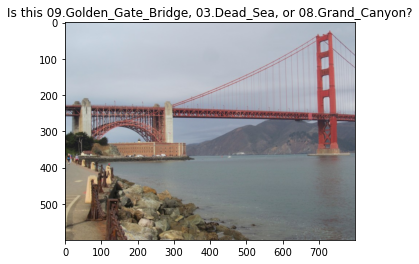

In [25]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    
    # open image
    img = Image.open(img_path)
    
    # plot image with 3 top predicted labels
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title('Is this {}, {}, or {}?'.format(predicted_landmarks[0],
                                                 predicted_landmarks[1], 
                                                 predicted_landmarks[2]))
    plt.show()
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

There is always room for improvement :)
1. Adjust learning rate and epochs
2. Change data augmentation (I would go for the colors then)
3. Resizing images to a larger resolution (but this would have negative effects on the computation time)
etc. pp., there is a lot more that you can do

(added from review: if there is class imbalance, SMOTE can used as an resampling technique)

This model can be used for other object recognition (e.g. skin cancer detection) tasks as well, but I would say mostly for landscape fotographs with horizontal allignment, e.g. detecting subtrain stations of cities on photos. It can be applies to other areas as well, but due to its low accuracy and that objects are solely landmarks, I would only for application areas where edifices and structures etc. should be detected.

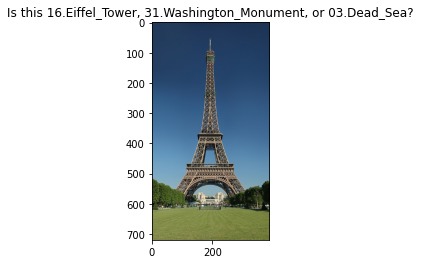

In [26]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('images/aim/389px-Tour_Eiffel_Wikimedia_Commons.jpg')

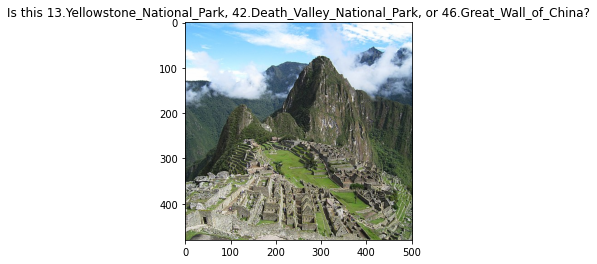

In [27]:
suggest_locations('images/aim/502px-Before_Machu_Picchu.jpg')

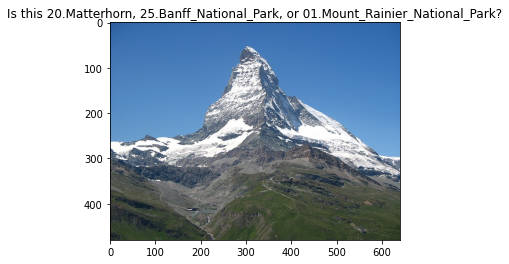

In [28]:
suggest_locations('images/aim/640px-3818_-_Riffelberg_-_Matterhorn_viewed_from_Gornergratbahn.JPG')

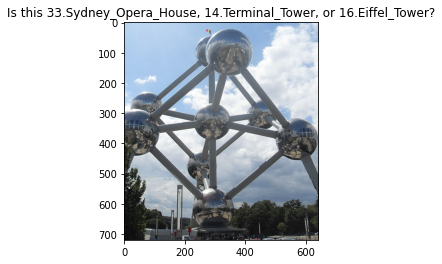

In [29]:
suggest_locations('images/aim/643px-Atomium_Brussels.jpg')

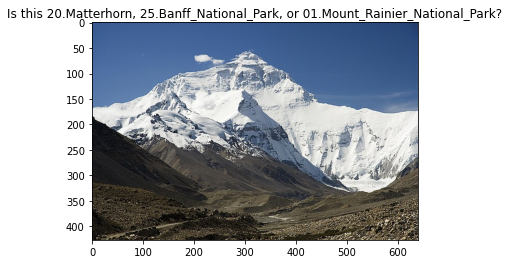

In [30]:
# class not in data, just for testing
suggest_locations('images/aim/640px-Everest_North_Face_toward_Base_Camp_Tibet_Luca_Galuzzi_2006.jpg')